###### Lab 03 - Bringing it together
```python
student = 'David Harris - MSc, GIS Candidate'
course = 'GIS 618 - Advanced Python Scripting for GIS'
date = '04-05-2020'
assignment = 'Lab-03'
```

## NYC Taxi and For Hire App Service Visualization by Taxi Zone

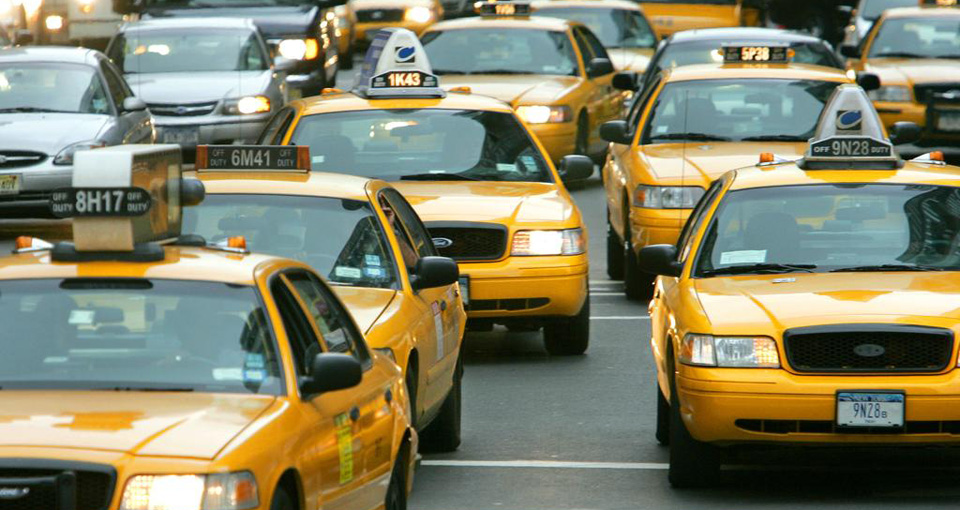

## Goals 

The goals of this notebook are as follows:

1. Join different datasets of Yellow Taxi, Green Taxi, and For Hire App Services into one tidy dataset.
2. Examine these data in dynamic maps to see large scale patterns of usage in NYC. 
3. Look at some auxiliary data to assess possible predictive factors for ride type usage. 

To use this data, an ArcGIS license is required.  This notebook does have several cells that actively publish information to a user's portal.   These cells are clearly marked and can be avoided if that is desired. It all starts with the imports below:


In [2]:
# Arcgis API for Python imports
from arcgis.gis import GIS
from arcgis.features import GeoAccessor
from arcgis.features.enrich_data import enrich_layer
from arcgis.geoenrichment import Country

# Python data science library imports
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

# Python standard library imports
import requests
import tempfile
import shutil

# Matplotlib magic inline command 
%matplotlib inline

## Part 1: Parsing Ride Data by Type and Location 

Below is a workflow to join taxi data and for hire vehicle app services.  The workflow reliess on the use of data from https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page, and is built to work with one month of data. The three CSV at the top of the cell below reflect data from one month of NYC ride data, and these links may easily be swapped out with data from another month and the analysis will run the same provided the aspects of the data structure described below are met.

In [3]:
yellow = pd.read_csv('https://nyc-tlc.s3.amazonaws.com/trip+data/yellow_tripdata_2019-11.csv', low_memory= False)
green = pd.read_csv('https://nyc-tlc.s3.amazonaws.com/trip+data/green_tripdata_2019-11.csv', low_memory= False)
fhv = pd.read_csv('https://nyc-tlc.s3.amazonaws.com/trip+data/fhvhv_tripdata_2019-11.csv', low_memory= False)


fhv.fillna(0, inplace=True)
yellow.fillna(0, inplace=True)
green.fillna(0, inplace=True)
uber = pd.DataFrame(fhv[fhv['hvfhs_license_num'] == 'HV0003'])#generating an Uber specific dataFrame
lyft = pd.DataFrame(fhv[fhv['hvfhs_license_num'] == 'HV0005'])#generating a Lyft specific dataFrame
o_fhv = pd.DataFrame(fhv[(fhv['hvfhs_license_num'] != 'HV0005') & 
                         (fhv['hvfhs_license_num'] != 'HV0003')])#generating a dataframe for other services

yellow['Ride_Type'], yellow['FHV_Flag'] = 'Yellow', 0
yellow['Date'] = pd.to_datetime(yellow['tpep_pickup_datetime']).dt.date
green['Ride_Type'], green['FHV_Flag'] = 'Green', 0 
green['Date'] = pd.to_datetime(green['lpep_pickup_datetime']).dt.date
uber['Ride_Type'], uber['FHV_Flag'] = 'Uber', 1
uber['Date'] = pd.to_datetime(uber['pickup_datetime']).dt.date
lyft['Ride_Type'], lyft['FHV_Flag'] = 'Lyft', 1
lyft['Date'] = pd.to_datetime(lyft['pickup_datetime']).dt.date
o_fhv['Ride_Type'], o_fhv['FHV_Flag'] = 'Other', 1
o_fhv['Date'] = pd.to_datetime(o_fhv['pickup_datetime']).dt.date

#generate single tidy dataset
nov_rides = pd.concat([yellow, green, uber, lyft, o_fhv], join='inner')
nov_rides['Date'] = pd.to_datetime(nov_rides['Date'])
nov_rides = nov_rides[(nov_rides.Date >= '2019-11-1') & (nov_rides.Date < '2019-12-1')]
nov_rides.head()

,PULocationID,DOLocationID,Ride_Type,FHV_Flag,Date
0,145,145,Yellow,0,2019-11-01
1,145,145,Yellow,0,2019-11-01
2,193,193,Yellow,0,2019-11-01
3,193,193,Yellow,0,2019-11-01
4,226,226,Yellow,0,2019-11-01


### Methods:

The above cell is working to break down the three CSV files of Yellow Taxi, Green Taxi, and For Hire Vehicles into one usable dataset.  This dataset will be used to evaluate ride patterns in the city between taxis and for hire vehicles for the month of November in 2019.  The available data stops after December of 2019. November was chosen because the Christmas holiday at the end of December contains some irregular patterns, thus November 2019 is the most recent data available to analyze that reflects general patterns of for hire vehicles in the city.  If the taxi zone ID numbers remain the same and the data structure of each month of ride data remains the same, this script may be effectively used for any month of ride data by simply substituting out the CSV link for each ride type to the month of interest. The key data elements of the CSV's that this script relies on are as follows:

1. The Yellow Taxi table stores it's pickup date in the column `tpep_pickup_datetime`
2. The Green Taxi table stores it's pickup date in the column `lpep_pickup_datetime`
3. the High Volume For Hire Service (HVFHS) data stores it's pickup date in the column `pickup_datetime` **and** the HVFHS table stores the company licensing information in the column titled `hvfhs_license_num`

The remainder of the script will work with the joined CSV's above to create first a plot showing the daily total rides by ride type in NYC.  The data is then joined to a feature layer of taxi zones that is downloaded and published within the script from a link ([]).  The script then calculates some basic information about each pickup zone for each ride, summing total counts of pickups and drop-offs, summing the same counts by ride type, and creating percentage variables for Taxi pickups and drop-offs, and For Hire Service (FHS) pickup and drop-offs.  

A map of zones with the highest number of FHS pickups is generated, as well as a map showing the zones with the highest percentages of Taxi pickups. 

The cell above will take a couple of minutes to run.  

[Text(0, 0.5, 'Count'), Text(0.5, 0, 'Date')]

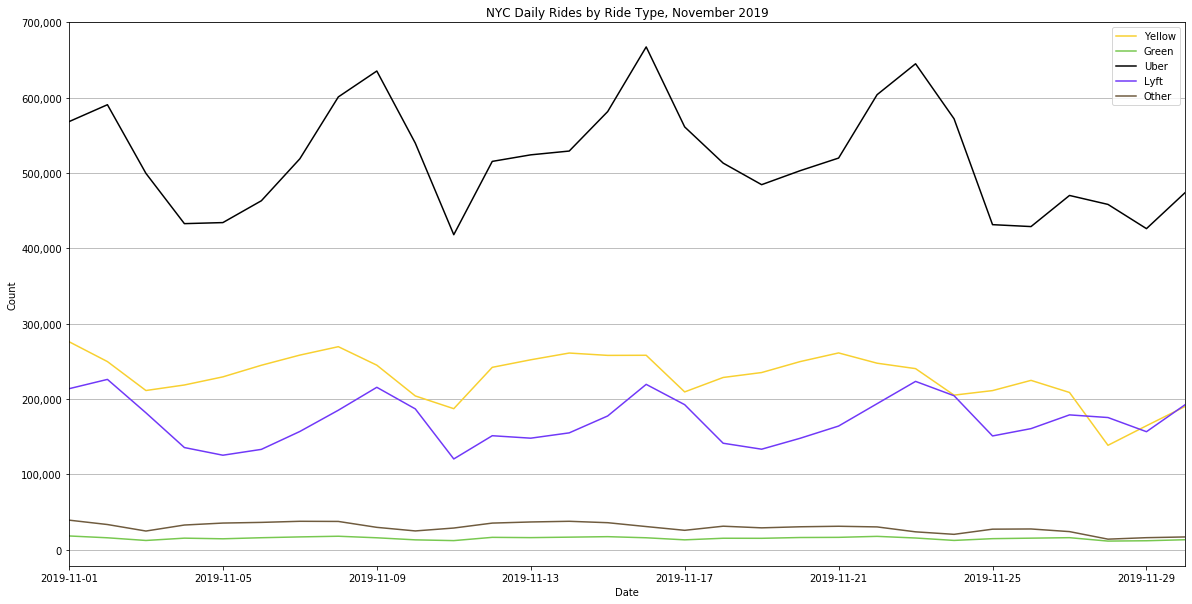

In [4]:
def date_count(df, col_name, date_field): # custom function to create counts of each ride type by day for following plot
    df[col_name] = pd.to_datetime(df[date_field]).dt.date
    df.index = df[col_name]
    i_counts = df.index.value_counts()
    new_df = pd.DataFrame(i_counts)
    return new_df

vehicle_type_colors = [
                      '#F8D030', # Yellow taxi
                      '#78C850',  # Green taxi
                      '#000000',  # Uber
                      '#7038F8',  # lyft
                      '#6F5B3E',  # Other For Hire Vehicle
                      ]
# Merge different ride types into one data frame to plot
nov_rtypes = date_count(pd.DataFrame(nov_rides[(nov_rides.Ride_Type=='Yellow')]), 'Yellow', 'Date').merge(
                date_count(pd.DataFrame(nov_rides[(nov_rides.Ride_Type=='Green')]), 'Green', 'Date'), 
                    left_index=True, right_index=True).merge(
                date_count(pd.DataFrame(nov_rides[(nov_rides.Ride_Type=='Uber')]), 'Uber', 'Date'), 
                    left_index=True, right_index=True).merge(
                date_count(pd.DataFrame(nov_rides[(nov_rides.Ride_Type=='Lyft')]), 'Lyft', 'Date'),
                    left_index=True, right_index=True).merge(
                date_count(pd.DataFrame(nov_rides[(nov_rides.Ride_Type=='Other')]), 'Other', 'Date'), 
                    left_index=True, right_index=True)

fig = nov_rtypes.plot(figsize=(20,10), #chart properties set here
                      legend=True,
                      color=vehicle_type_colors,
                      title='NYC Daily Rides by Ride Type, November 2019')
fig.grid('on', which='major', axis='y')
fig.set_yticklabels(['{:,}'.format(int(x)) for x in fig.get_yticks().tolist()])
fig.set(xlabel='Date', ylabel='Count') 

The above plot shows several trends in taxi and FHS ride patterns in November 2019.  First we can observe the peaks and valleys corresponding the days of the week, with the highest peaks occurring on the weekends, and valleys in the middle of the week.  

The data also show that Uber is the clear favorite ride service of choice, city wide, followed by Yellow Taxi, and then Lyft. Other FHS companies combine to generate more than Green Taxi on average by a relatively slim margin. Green Taxi, a service specifically designed to pickup passengers from the outer boroughs and bring riders to the city, is the least used single service. [https://www1.nyc.gov/site/tlc/businesses/green-cab.page].  

In [5]:
#generate statistics 
avg_ride = format(nov_rides.groupby('Date').size().mean(), ',')#average total rides per day
avg_fhv = format(nov_rides[(nov_rides.FHV_Flag==1)].groupby('Date').size().mean(), ',')#average total rides by FHV
avg_taxi = format(nov_rides[(nov_rides.FHV_Flag==0)].groupby('Date').size().mean(), ',')#average total rides by taxi service
print(f'''AVERAGE RIDES PER DAY, Nov_2019:
Total: {avg_ride}
For Hire App services : {avg_fhv}
Taxi Services: {avg_taxi}
''')
tot_uber = format(len(uber), ',')#count of total uber rides
tot_yellow = format(len(yellow), ',')#total yellow taxi
tot_lyft = format(len(lyft), ',')#total lyft
tot_o = format(len(o_fhv), ',')#total other FHV
tot_g = format(len(green), ',')#total green
tot = format(len(nov_rides), ',')#total Rides in NYC
print(f'''TOTAL RIDES BY TYPE, Nov_2019:
Uber: {tot_uber}
Yellow Taxi: {tot_yellow}
Lyft: {tot_lyft}
Other For Hire App Service: {tot_o}
Green Taxi: {tot_g}

TOTAL RIDES IN NYC, Nov_2019
{tot}''')

AVERAGE RIDES PER DAY, Nov_2019:
Total: 965,414.6
For Hire App services : 721,183.6
Taxi Services: 244,231.0

TOTAL RIDES BY TYPE, Nov_2019:
Uber: 15,610,941
Yellow Taxi: 6,878,111
Lyft: 5,144,737
Other For Hire App Service: 879,830
Green Taxi: 449,500

TOTAL RIDES IN NYC, Nov_2019
28,962,438


The plot above and accompanying statistics provide some background on city wide data for each ride type, and daily average numbers of rides in the city.  Next, the script will join the data developed above to a taxi zone shapefile to provide more detailed information of where each ride service exists. To do this, the script will first need to publish the shapefile and call the published layer into the script as a table.  This will allow for the data above to be examined spatially for patterns for each ride type.  

To do this, the script will utilize a connection to ArcGIS online or an enterprise instance of ArcGIS. The next cell shows how a user that is signed into a portal via ArcGIS Pro can connect to their GIS through the script: 

In [6]:
#connect to GIS
gis = GIS('pro')
gis.properties.user.username

'dharr152_GISandData'

Note that running the next cell will actively publish a layer to the user's portal if that user is connected to an AGOL environment or ArcGIS enterprise instance through ArcGIS Pro.  If this isn't desired, skip the next cell.

In [6]:
#download shapefile   
with tempfile.TemporaryDirectory() as tempdir: 
    url = r'https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip'
    response = requests.get(url, stream=True)
    taxi_zones = f'{tempdir}/taxi_zones7.zip'
    with open(taxi_zones, 'wb') as fd:
        for chunk in response.iter_content(chunk_size=128):
            fd.write(chunk)
    shpfile = gis.content.add({}, taxi_zones)

#publish shapefile to portal
url2 = 'https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page'
t_zones = shpfile.publish()
item_properties = {'snippet': f'The data for this feature layer was downloaded from the following link:  {url}\
                   The metadata and auxiliary data to support this shapefile can be found here: {url2}',
                  'title': 'NYC Taxi Zones',
                  'tags': ['NYC','Taxi Zones', 'opendata']} 
t_zones.update(item_properties)

True

In [7]:
t_zones.id

'449353c8ca3449aaa07e56a8203e183f'

The cell below is bringing a taxi zones layer into the script that was previously published through the authors portal.  If the previous two cells were executed and the user wants to use this data, the content ID can be copied from the printout immediately above this cell.  The next two cells show the details of the published layer above, and the same data represented as a table or Data Frame, that will be used to join the data developed above to taxi zones. 

<Item title:"NYC Taxi Zones" type:Feature Layer Collection owner:dharr152_GISandData>
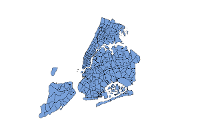

In [7]:
item = gis.content.get("3317c43b702e424f82a38505d620993b")
item

The next cell will show the data strcuture of the feature layer.  Note that the `SHAPE` variable is where the geometry of that zone is stored, and will be used to display this data in a map widget below.

In [8]:
taxi_zones = item.layers[0]
sdf = GeoAccessor.from_layer(taxi_zones)
sdf.head()

,FID,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,Shape__Area,Shape__Length,SHAPE
0,1,1,0.116357,0.000782,Newark Airport,1,EWR,1.278558e+07,15147.850236,"{'rings': [[[-8258175.70022175, 4967458.413919..."
1,2,2,0.433470,0.004866,Jamaica Bay,2,Queens,2.322694e+07,107613.691475,"{'rings': [[[-8217980.77615339, 4959238.495626..."
2,3,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,5.151979e+06,10262.217058,"{'rings': [[[-8220713.69083401, 4993384.374985..."
3,4,4,0.043567,0.000112,Alphabet City,4,Manhattan,1.299172e+06,4549.487632,"{'rings': [[[-8234500.38707674, 4971985.306872..."
4,5,5,0.092146,0.000498,Arden Heights,5,Staten Island,8.121396e+06,11921.922530,"{'rings': [[[-8257036.27506697, 4948034.299763..."


Now that the script has generated a dataset with the geometries of each zone as well as the location ID, the script can now develop a new data table with statistics of each ride type.  The data below will print out to show what data has been created for each zone. The data created is as follows:

1. Total pickups and dropoffs for each type individually
2. Total pickups and dropoffs by broad type (i.e. Taxi service, or For Hire App service)
3. The percent of pickups and dropoffs in each zone that are in these two broad categories.

In [9]:
def count_merge(df1, join_field1, df2, join_field2, count_field):# Custom fucntion to join counts by type to each taxi zone
    locs = df2.groupby([join_field2]).size()
    counts = pd.DataFrame(locs)
    joined = pd.merge(left=df1,
                 right=counts,
                 how='outer',
                 left_on=join_field1,
                 right_on=join_field2,
                 right_index=True)
    joined.rename(columns={0:count_field}, inplace=True)
    return joined

lid = pd.DataFrame(sdf['LocationID'])
upu = count_merge(lid, 'LocationID', nov_rides[(nov_rides.Ride_Type=='Uber')], 'PULocationID', 'Uber_Pickups')
udo = count_merge(upu, 'LocationID', nov_rides[(nov_rides.Ride_Type=='Uber')], 'DOLocationID', 'Uber_Dropoffs')
lpu = count_merge(udo, 'LocationID', nov_rides[(nov_rides.Ride_Type=='Lyft')], 'PULocationID', 'Lyft_Pickups')
ldo = count_merge(lpu, 'LocationID', nov_rides[(nov_rides.Ride_Type=='Lyft')], 'DOLocationID', 'Lyft_Dropoffs')
opu = count_merge(ldo, 'LocationID', nov_rides[(nov_rides.Ride_Type=='Other')], 'PULocationID', 'Other_Pickups')
odo = count_merge(opu, 'LocationID', nov_rides[(nov_rides.Ride_Type=='Other')], 'DOLocationID', 'Other_Dropoffs')
gpu = count_merge(odo, 'LocationID', nov_rides[(nov_rides.Ride_Type=='Green')], 'PULocationID', 'Green_Pickups')
gdo = count_merge(gpu, 'LocationID', nov_rides[(nov_rides.Ride_Type=='Green')], 'DOLocationID', 'Green_Dropoffs')
ypu = count_merge(gdo, 'LocationID', nov_rides[(nov_rides.Ride_Type=='Yellow')], 'PULocationID', 'Yellow_Pickups')
ydo = count_merge(ypu, 'LocationID', nov_rides[(nov_rides.Ride_Type=='Yellow')], 'DOLocationID', 'Yellow_Dropoffs')
ydo.fillna(0, inplace=True)
ydo['FHV_Pickups'] = ydo.Uber_Pickups + ydo.Lyft_Pickups
ydo['FHV_Dropoffs'] = ydo.Uber_Dropoffs + ydo.Lyft_Dropoffs
ydo['Taxi_Pickups'] = ydo.Yellow_Pickups + ydo.Green_Pickups
ydo['Taxi_Dropoffs'] = ydo.Yellow_Dropoffs + ydo.Green_Dropoffs
ydo['Tot_Pickups'] = ydo.Uber_Pickups + ydo.Lyft_Pickups + ydo.Yellow_Pickups + ydo.Green_Pickups
ydo['Tot_Dropoffs'] = ydo.Uber_Dropoffs + ydo.Lyft_Dropoffs + ydo.Yellow_Dropoffs + ydo.Green_Dropoffs
ydo['P_FHV_Pickups'] = round(ydo.FHV_Pickups / ydo.Tot_Pickups * 100)
ydo['P_FHV_Dropoffs'] = round(ydo.FHV_Dropoffs / ydo.Tot_Dropoffs *100)
ydo['P_Taxi_Pickups'] = round(ydo.Taxi_Pickups / ydo.Tot_Pickups * 100)
ydo['P_Taxi_Dropoffs'] = round(ydo.Taxi_Dropoffs / ydo.Tot_Dropoffs *100)

The next line will join this data to the feature layer data:

In [10]:
spat_taxi = sdf.merge(ydo, left_on='LocationID', right_on='LocationID', left_index=True)
spat_taxi.head()

,FID,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,Shape__Area,Shape__Length,SHAPE,...,FHV_Pickups,FHV_Dropoffs,Taxi_Pickups,Taxi_Dropoffs,Tot_Pickups,Tot_Dropoffs,P_FHV_Pickups,P_FHV_Dropoffs,P_Taxi_Pickups,P_Taxi_Dropoffs
0.0,1,1,0.116357,0.000782,Newark Airport,1,EWR,1.278558e+07,15147.850236,"{'rings': [[[-8258175.70022175, 4967458.413919...",...,12.0,125377.0,860.0,15595.0,872.0,140972.0,1.0,89.0,99.0,11.0
1.0,2,2,0.433470,0.004866,Jamaica Bay,2,Queens,2.322694e+07,107613.691475,"{'rings': [[[-8217980.77615339, 4959238.495626...",...,21.0,45.0,2.0,15.0,23.0,60.0,91.0,75.0,9.0,25.0
2.0,3,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,5.151979e+06,10262.217058,"{'rings': [[[-8220713.69083401, 4993384.374985...",...,40919.0,39418.0,639.0,1091.0,41558.0,40509.0,98.0,97.0,2.0,3.0
3.0,4,4,0.043567,0.000112,Alphabet City,4,Manhattan,1.299172e+06,4549.487632,"{'rings': [[[-8234500.38707674, 4971985.306872...",...,78438.0,67226.0,11619.0,28587.0,90057.0,95813.0,87.0,70.0,13.0,30.0
4.0,5,5,0.092146,0.000498,Arden Heights,5,Staten Island,8.121396e+06,11921.922530,"{'rings': [[[-8257036.27506697, 4948034.299763...",...,5143.0,5004.0,28.0,64.0,5171.0,5068.0,99.0,99.0,1.0,1.0


Now this data may be displayed using map widgets, and the next two cells will each produce a dynamic map to explore the data by taxi zone.  

The first map displays the hottest zones of the total  number of non-taxi for hire services, and the 2nd map shows the zones with the highest percents of Taxi pickups

In [11]:
m1 = gis.map('NY', zoomlevel=11)
spat_taxi.spatial.plot(map_widget=m1,
                       title='Total FHV Pickups',      
                       renderer_type = 'c', 
                       method='esriClassifyNaturalBreaks',
                       class_count=10,
                       col='P_Taxi_Pickups',
                       cmap='afmhot_r',
                       alpha=0.8)
m1

MapView(layout=Layout(height='400px', width='100%'), zoom=11.0)

In [12]:
m2 = gis.map('NY', zoomlevel=11)
spat_taxi.spatial.plot(map_widget=m2, 
                renderer_type = 'c', 
                method='esriClassifyNaturalBreaks',
                class_count=10,
                col='FHV_Pickups',
                cmap='afmhot_r',
                alpha=0.8)
m2

MapView(layout=Layout(height='400px', width='100%'), zoom=11.0)

These maps may be explored dynamically. Pop-ups for each zone will display the aggregated statistics for each taxi zone.  

## Part 2: Accessing auxiliary information and joining data to taxi zones to identify patterns

The next part of the script will access information from the American Community Survey (ACS) and the most recent Census by leveraging the `geoenrichment` functions of ArcGIS. 

In [13]:
usa = Country.get('US')
df = usa.data_collections

The next cell will show the names of all the available data collections in the US, as well as the number of variables associated with each collection.  From this list, a title can be copied and pasted when prompted in the next cell.  This will print out all the variables of interest from that collection.  For this script, the collections called `populationtotals` has been used.  When prompted, you may enter that in the prompt to continue running the sample script. This analysis then selects 6  variables from the `populationtotals` collection list in the following cells.  Most data collections are too large to publish as a feature service so only features of interest should be selected. 

In [14]:
ids = df.groupby(df.index)
for k, v in ids:
    print(f'{k}, {len(v)}')

1yearincrements, 576
5yearincrements, 187
ACS_Housing_Summary_rep, 84
ACS_Population_Summary_rep, 146
Age, 36
AgeDependency, 12
Age_50_Profile_rep, 88
Age_by_Sex_Profile_rep, 5
Age_by_Sex_by_Race_Profile_rep, 14
AtRisk, 64
AutomobilesAutomotiveProducts, 252
Automotive_Aftermarket_Expenditures_rep, 64
BabyProductsToysGames, 110
Business_Summary_rep, 1
CivicActivitiesPoliticalAffiliation, 63
ClothingShoesAccessories, 213
Community_Profile_rep, 78
DaytimePopulation, 4
Demographic_and_Income_Comparison_Profile_rep, 22
Demographic_and_Income_Profile_rep, 24
Disposable_Income_Profile_rep, 8
ElectronicsInternet, 446
Electronics_and_Internet_Market_Potential_rep, 24
Executive_Summary_rep, 1
Finances_Market_Potential_rep, 1
FinancialInsurance, 379
Financial_Expenditures_rep, 54
Generations, 14
Graphic_Profile_rep, 11
GroceryAlcoholicBeverages, 330
Health, 423
HealthPersonalCare, 307
HealthPersonalCareCEX, 366
Health_and_Beauty_Market_Potential_rep, 7
HistoricalHouseholds, 10
HistoricalHousing, 

In [15]:
var = df.loc[input('Enter data collection title of interest here:')]
var.set_index('analysisVariable').to_dict()['alias']
enrichment_variables = var.set_index('analysisVariable').to_dict()['alias']
enrichment_variables

Enter data collection title of interest here:populationtotals


{'populationtotals.TOTPOP_CY': '2019 Total Population',
 'populationtotals.HHPOP_CY': '2019 Population in Households',
 'populationtotals.FAMPOP_CY': '2019 Population in Families',
 'populationtotals.POPDENS_CY': '2019 Population Density',
 'populationtotals.DPOP_CY': '2019 Total Daytime Population',
 'populationtotals.POPGRW10CY': '2010-2019 Growth Rate: Population',
 'populationtotals.DPOPWRK_CY': '2019 Daytime Pop: Workers',
 'populationtotals.DPOPRES_CY': '2019 Daytime Pop: Residents',
 'populationtotals.DPOPDENSCY': '2019 Daytime Pop Density',
 'populationtotals.TOTPOP_FY': '2024 Total Population',
 'populationtotals.HHPOP_FY': '2024 Population in Households',
 'populationtotals.FAMPOP_FY': '2024 Population in Families',
 'populationtotals.POPDENS_FY': '2024 Population Density',
 'populationtotals.POPGRWCYFY': '2019-2024 Growth/Yr: Population',
 'populationtotals.TOTPOP10': '2010 Total Population',
 'populationtotals.POPDENS10': '2010 Population Density',
 'populationtotals.MALES1

In [16]:
#create mew dataframe with variable names and definitions for reference
enrichment_variables = {'populationtotals.TOTPOP_CY': '2019 Total Population',
 'populationtotals.HHPOP_CY': '2019 Population in Households',
 'populationtotals.FAMPOP_CY': '2019 Population in Families',
 'populationtotals.POPDENS_CY': '2019 Population Density',
 'populationtotals.DPOP_CY': '2019 Total Daytime Population',
 'populationtotals.POPGRW10CY': '2010-2019 Growth Rate: Population'}

enrichment_variables_df = pd.DataFrame.from_dict(enrichment_variables, orient='index',columns=['Variable Definition'])
enrichment_variables_df.reset_index(level=0, inplace=True)
enrichment_variables_df.columns = ['AnalysisVariable','Variable Definition']

As before, note that this will actively publish a new layer to the user's portal.  To avoid this step, see several cells below for the item ID, call the item appropriately.

In [17]:
#add variables to published feature layer and re-publish as new layer
variable_names = enrichment_variables_df['AnalysisVariable'].tolist()
taxi_zones_enriched = enrich_layer(taxi_zones,
                                  analysis_variables=variable_names,
                                  output_name='taxi_zones_enriched_DH')
sdf_taxi_zones = taxi_zones_enriched.layers[0].query().sdf

In [19]:
url = r'https://s3.amazonaws.com/nyc-tlc/misc/taxi_zones.zip'
item_properties = {'snippet': f'The data for this feature layer was downloaded from the following link:  {url}\
                   Data from US geo-enrichment collections have been added to allow for analysis of\
                   geographical characteristics',
                  'title': 'Geo-Enriched NYC Taxi Zones',
                  'tags': ['NYC','Taxi Zones', 'opendata', 'geoenrichment']} 
taxi_zones_enriched.update(item_properties)
display(taxi_zones_enriched)

<Item title:"Geo-Enriched NYC Taxi Zones" type:Feature Layer Collection owner:dharr152_GISandData>

In [20]:
taxi_zones_enriched.id
#item = gis.content.get('id below here')
#item

'23e3c983c40a421a935ea9b0d9f56c36'

In [21]:
#generate statistics on population characteristics in NYC
pop_tot = format(sum(sdf_taxi_zones['TOTPOP_CY']), ',')#total population in NYC
pop_house = format(sum(sdf_taxi_zones['HHPOP_CY']), ',')#total population in a household in nyc
pop_fam = format(sum(sdf_taxi_zones['FAMPOP_CY']), ',')#total population with families in nyc
pop_day = format(sum(sdf_taxi_zones['DPOP_CY']), ',')#total daytime population in nyc

mean_dens = format(sdf_taxi_zones['POPDENS_CY'].mean(), ',.2f')#mean density per congressional district
mean_gro = format(sdf_taxi_zones['POPGRW10CY'].mean(), ',.2f')#mean 10 year growth rate
print(f'''POPULATION CHARACTERISTICS FOR NYC, Nov_2019
Total: {pop_tot}
Living in Home: {pop_house}
In a Family: {pop_fam}
Daytime Population (includes commuters): {pop_day}

AVERAGE CHARACTERISTICS BY TAXI ZONE, Nov_2019:
Population Density per Congressional Disrict: {mean_dens}
10-Year Population Growth Rate: {mean_gro}''')

POPULATION CHARACTERISTICS FOR NYC, Nov_2019
Total: 8,626,359
Living in Home: 8,445,530
In a Family: 6,439,729
Daytime Population (includes commuters): 9,345,731

AVERAGE CHARACTERISTICS BY TAXI ZONE, Nov_2019:
Population Density per Congressional Disrict: 44,392.88
10-Year Population Growth Rate: 0.57


The first map shows the areas with the highest total population per zone.  The darkest areas have over 1,000,000 residents in each zone. 

In [22]:
m3 = gis.map('NY', zoomlevel=11)
sdf_taxi_zones.spatial.plot(map_widget=m3, 
                renderer_type = 'c', 
                method='esriClassifyNaturalBreaks',
                class_count=8,
                col='TOTPOP_CY',
                cmap='YlGnBu',
                alpha=0.8)
m3

MapView(layout=Layout(height='400px', width='100%'), zoom=11.0)

The next map shows the population density in New York City. Visually, this appears to show some correlation to the areas that have higher percentages of taxi usage. 

In [23]:
m3 = gis.map('NY', zoomlevel=11)
sdf_taxi_zones.spatial.plot(map_widget=m3, 
                renderer_type = 'c', 
                method='esriClassifyNaturalBreaks',
                class_count=8,
                col='POPDENS_CY',
                cmap='YlGnBu',
                alpha=0.8)
m3

MapView(layout=Layout(height='400px', width='100%'), zoom=11.0)

Next the script joins the same variables developed earlier on ride types to the new feature layer for further analysis.

In [24]:
tz_new = sdf_taxi_zones.merge(ydo, how='inner', left_on='LocationID', right_on='LocationID', left_index=True)
tz_new.drop_duplicates(subset ="LocationID", 
                     keep = 'first', inplace = True) 
tz_new.fillna(0, inplace=True)
tz_new.shape

(260, 42)

In [25]:
tz_new.head()

,OBJECTID_1,OBJECTID,Shape_Leng,zone,LocationID,borough,Shape__Area,Shape__Length,ID,sourceCountry,...,FHV_Pickups,FHV_Dropoffs,Taxi_Pickups,Taxi_Dropoffs,Tot_Pickups,Tot_Dropoffs,P_FHV_Pickups,P_FHV_Dropoffs,P_Taxi_Pickups,P_Taxi_Dropoffs
102.0,1,103,0.014306,Governor's Island/Ellis Island/Liberty Island,103,Manhattan,103460.082031,1766.715829,0,US,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11.0,2,12,0.036661,Battery Park,12,Manhattan,176308.921875,2310.922493,1,US,...,2826.0,4101.0,2466.0,3899.0,5292.0,8000.0,53.0,51.0,47.0,49.0
55.0,3,57,0.019270,Corona,56,Queens,294871.980469,2509.241940,2,US,...,57218.0,53148.0,2062.0,6618.0,59280.0,59766.0,97.0,89.0,3.0,11.0
152.0,5,153,0.024737,Marble Hill,153,Manhattan,532120.097656,3122.127101,4,US,...,21122.0,17624.0,303.0,493.0,21425.0,18117.0,99.0,97.0,1.0,3.0
185.0,6,186,0.024696,Penn Station/Madison Sq West,186,Manhattan,606415.082031,3124.290248,5,US,...,172670.0,219292.0,246564.0,176848.0,419234.0,396140.0,41.0,55.0,59.0,45.0


To assess if population characteristics might be used to predict ride usage, the script conducts three simple regression analyses using population density [^1] The next steps will create these simple simple regressions to determine what effect, if any, population characteristics may have on rides per zone in NYC.

[^1]: https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

#### Linear Regression 1: Assessing Population Density and Taxi Pickups

In [26]:
X = tz_new['POPDENS_CY'].values.reshape(-1,1)
y = tz_new['Taxi_Pickups'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
print(f'''
Test Model Coefficient: {format(regressor.coef_[0][0], '.2f')}''')


Test Model Coefficient: 0.70


#### Linear Regression 2: Assessing Population Density and Total Pickups

In [27]:
X = tz_new['POPDENS_CY'].values.reshape(-1,1)
y = tz_new['Tot_Pickups'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
print(f'''
Test Model Coefficient: {format(regressor.coef_[0][0], '.2f')}''')


Test Model Coefficient: 1.64


#### Linear Regression 3: Assessing Population Density and For Hire App Services

In [28]:
X = tz_new['POPDENS_CY'].values.reshape(-1,1)
y = tz_new['FHV_Pickups'].values.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
print(f'''
Test Model Coefficient: {format(regressor.coef_[0][0], '.2f')}''')


Test Model Coefficient: 0.95


The coefficient printed out above suggests that out of the possible factors influencing ride usage, `population density` and `FHV_Pickups` may show some association.  With a coefficient just under 0.95, the relationship between these variables does not rise to the level of statistical significance. However, it does suggest that these variables are more associated than other factors, and indicates that above other factors, population density may play a key role in the rise of For Hire App Services.

[Text(0, 0.5, 'Standardized Count'),
 Text(0.5, 0, 'FHV Pickups by Zone (First 25 Zones)')]

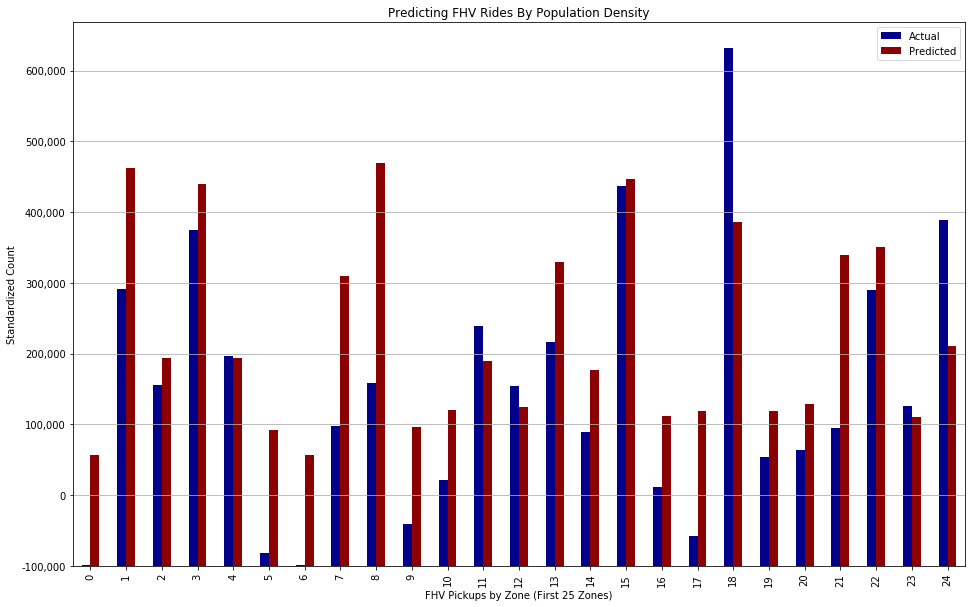

In [29]:
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df1=df.head(25)
fig2 = df1.plot(kind='bar',
                figsize=(16,10), 
                title='Predicting FHV Rides By Population Density',
               color=['#00008B','#8B0000'])
fig2.grid('on', which='major', axis='y')
fig2.set_yticklabels(['{:,}'.format(int(x)) for x in fig.get_yticks().tolist()])
fig2.set(xlabel='FHV Pickups by Zone (First 25 Zones)', ylabel='Standardized Count') 

As the chart above shows, the relationship between population density and ride share app pickups is far from predictive, and there are many zones that are clear outliers. Still, as the regression coeficients show, there is a correlative relationship between these two variables.  There are many possible reasons for these outliers, as will be described in greater detail below. 

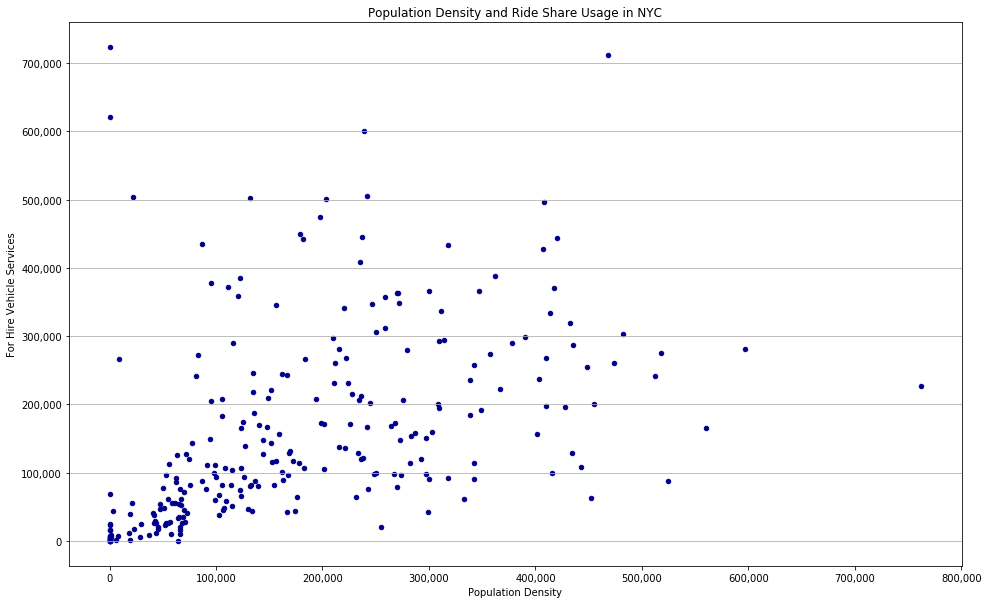

In [30]:
x = tz_new['POPDENS_CY'].values.reshape(-1,1).tolist()
y = tz_new['FHV_Pickups'].values.reshape(-1,1).tolist()
x = [item for row in x for item in row]
y = [item for row in y for item in row]
df2 = pd.DataFrame()
df2['Population Density'] = x
df2['For Hire Vehicle Services'] = y
fig3 = df2.plot.scatter( x='Population Density', 
                 y='For Hire Vehicle Services', 
                 figsize = (16,10), 
                 title='Population Density and Ride Share Usage in NYC',
                 color='#00008B')
fig3.set_yticklabels(['{:,}'.format(int(x)) for x in fig.get_yticks().tolist()])
fig3.set_xticklabels(['{:,}'.format(int(x)) for x in fig.get_yticks().tolist()])
fig3.grid('on', which='major', axis='y')

### Discussion:

Since the arrival of Uber, Lyft and other apps that offer similar services, Yellow taxi co. has been forever changed.  This is evidenced by the fact that over the past ten years, the company has seen its monthly usage drop in half, despite the fact that in that time, total rides for hire have more than doubled [^1].  Despite this, there are still specific geographies that show a higher than average usage of taxi services.  These are the three airports (JFK, Laguardia, and Newark) and areas in midtown Manhattan.  

Predicting what specific aspects of different areas are associated with higher taxi usage is a challenge.  The models presented above are just scratching the surface of the kinds of variables that may be examined.  Foot traffic, mixed use areas, and large business districts are all among the factors that may play a very important role in determining where for hire services are concentrated, and which areas show preferences for different types.  What is abundantly clear from the data, however, is that the outer boroughs show a massive preference for Uber and Lyft over traditional taxi services (Yellow taxi, and newer Green taxi's).

[^1]:https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page